# Activeloop Deep Memory

**How do we get +15% RAG hit_rate improvement for question answering on documentation?**

Retrieval-Augmented Generators (RAGs) have recently gained significant attention. As advanced RAG techniques and agents emerge, they expand the potential of what RAGs can accomplish. However, several challenges may limit the integration of RAGs into production. The primary factors to consider when implementing RAGs in production settings are accuracy (recall), cost, and latency. For basic use cases, OpenAI's Ada model paired with a naive similarity search can produce satisfactory results. Yet, for higher accuracy or recall during searches, one might need to employ advanced retrieval techniques. These methods might involve varying data chunk sizes, rewriting queries multiple times, and more, potentially increasing latency and costs.  [Activeloop's](https://activeloop.ai/) [Deep Memory](https://www.activeloop.ai/resources/use-deep-memory-to-boost-rag-apps-accuracy-by-up-to-22/) a feature available to Activeloop Deep Lake users, addresses these issuea by introducing a tiny neural network layer trained to match user queries with relevant data from a corpus. While this addition incurs minimal latency during search, it can boost retrieval accuracy by up to 27
% and remains cost-effective and simple to use, without requiring any additional advanced rag techniques.

In [ ]:
%pip install llama-index-vector-stores-deeplake
%pip install llama-index-llms-openai

In [ ]:
import nest_asyncio
import os
import getpass

nest_asyncio.apply()

In [ ]:
!pip install deeplake beautifulsoup4 html2text tiktoken openai llama-index python-dotenv

For this tutorial we will parse deeplake documentation, and create a RAG system that could answer the question from the docs. 

The tutorial can be divided into several parts:
1. [Dataset creation and uploading](#1-dataset-creation-and-ingestion)
2. [Generating synthetic queries and training deep_memory](#2-training-deep-memory)
3. [Evaluating deep memory performance](#3-deepmemory-evaluation)
4. [Deep Memory inference](#4-deep-memory-inference)

<a name="training"></a>
## 1. Dataset Creation and ingestion

Let me parse all of the links using BeautifulSoup and convert them into LlamaIndex documents:

In [ ]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin


def get_all_links(url):
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to retrieve the page: {url}")
        return []

    soup = BeautifulSoup(response.content, "html.parser")

    # Finding all 'a' tags which typically contain href attribute for links
    links = [
        urljoin(url, a["href"])
        for a in soup.find_all("a", href=True)
        if a["href"]
    ]

    return links

In [ ]:
from langchain.document_loaders import AsyncHtmlLoader
from langchain.document_transformers import Html2TextTransformer
from llama_index.core import Document


def load_documents(url):
    all_links = get_all_links(url)
    loader = AsyncHtmlLoader(all_links)
    docs = loader.load()

    html2text = Html2TextTransformer()
    docs_transformed = html2text.transform_documents(docs)
    docs = [Document.from_langchain_format(doc) for doc in docs_transformed]
    return docs


docs = load_documents("https://docs.deeplake.ai/en/latest/")

Fetching pages: 100%|##########| 120/120 [00:13<00:00,  8.70it/s]


In [ ]:
len(docs)

120

In [ ]:
from llama_index.core.evaluation import generate_question_context_pairs
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    StorageContext,
)
from llama_index.vector_stores.deeplake import DeepLakeVectorStore
from llama_index.core.node_parser import SimpleNodeParser
from llama_index.llms.openai import OpenAI


os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API token: ")
# # activeloop token is needed if you are not signed in using CLI: `activeloop login -u <USERNAME> -p <PASSWORD>`
os.environ["ACTIVELOOP_TOKEN"] = getpass.getpass(
    "Enter your ActiveLoop API token: "
)  # Get your API token from https://app.activeloop.ai, click on your profile picture in the top right corner, and select "API Tokens"

token = os.getenv("ACTIVELOOP_TOKEN")

vector_store = DeepLakeVectorStore(
    dataset_path="hub://activeloop-test/deeplake_docs_deepmemory2",
    overwrite=False,  # set to True to overwrite the existing dataset
    runtime={"tensor_db": True},
    token=token,
)

Deep Lake Dataset in hub://activeloop-test/deeplake_docs_deepmemory2 already exists, loading from the storage


In [ ]:
def create_modules(vector_store, docs=[], populate_vector_store=True):
    if populate_vector_store:
        node_parser = SimpleNodeParser.from_defaults(chunk_size=512)
        nodes = node_parser.get_nodes_from_documents(docs)
    else:
        nodes = []

    # by default, the node ids are set to random uuids. To ensure same id's per run, we manually set them.
    for idx, node in enumerate(nodes):
        node.id_ = f"node_{idx}"

    llm = OpenAI(model="gpt-4")
    storage_context = StorageContext.from_defaults(vector_store=vector_store)
    return storage_context, nodes, llm

In [ ]:
(
    storage_context,
    nodes,
    llm,
) = create_modules(
    docs=docs,
    vector_store=vector_store,
    # populate_vector_store=False, # uncomment this line to skip populating the vector store
)

In [ ]:
vector_index = VectorStoreIndex(nodes, storage_context=storage_context)
deep_memory_retriever = vector_index.as_retriever(
    similarity_top_k=4, deep_memory=True
)

<a name="training"></a>
## 2. Training Deep Memory

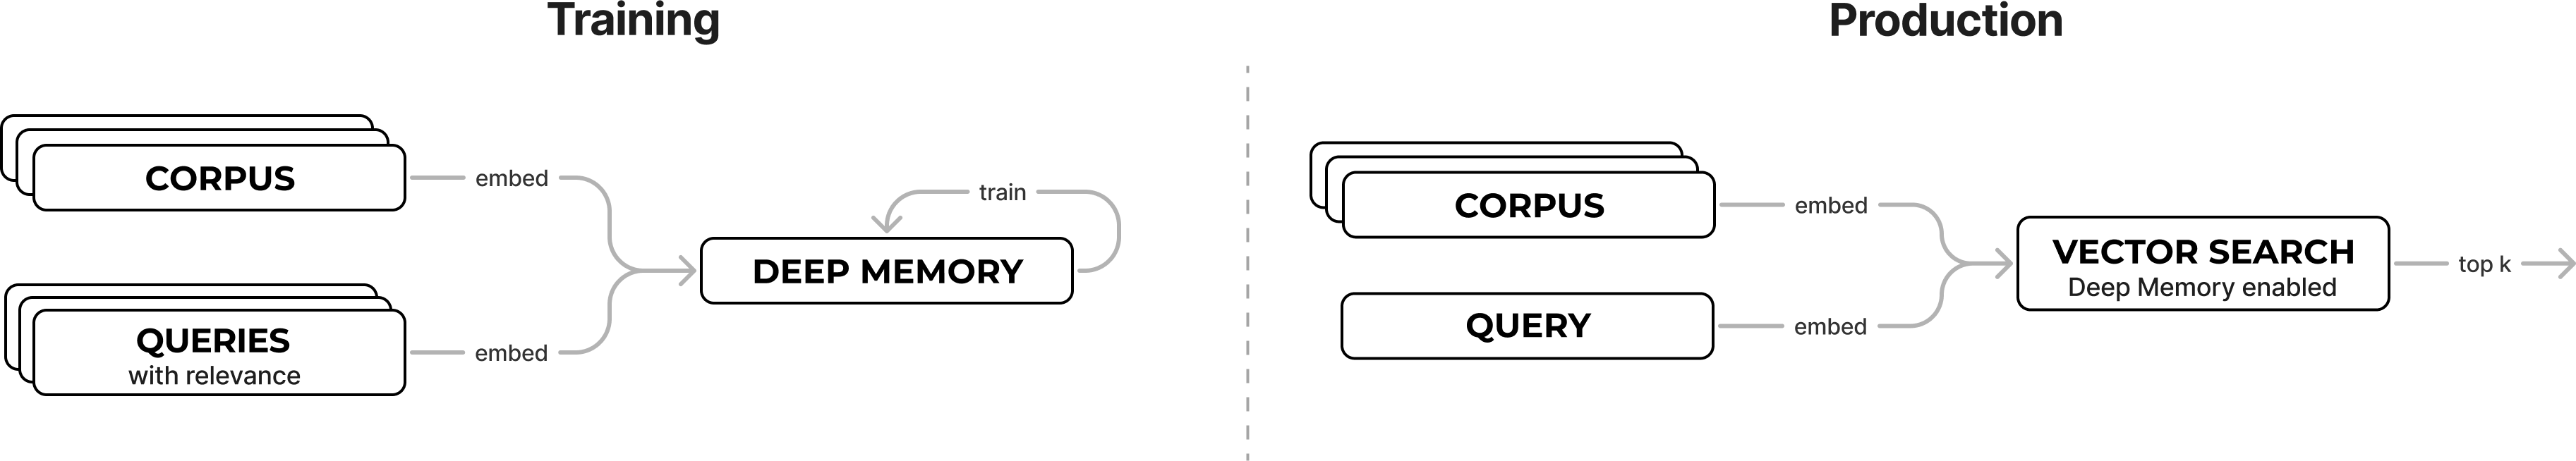

Here above, we showed the overall schema of how deep_memory works. So as you can see, in order to train it, you need relevance, queries together with corpus data (data that we want to query). The corpus data was already populated in the previous section; here, we will be generating questions and relevance.

1. `questions` - is a text of strings, where each string represents a query.
2. `relevance` - contains links to the ground truth for each question. There might be several docs that contain an answer to the given question. Because of this, relevance is List[List[tuple[str, float]]], where the outer list represents queries and the inner list relevant documents. The tuple contains a str, float pair where the string represents the id of the source doc (corresponds to the id tensor in the dataset), while the float corresponds to how much the current document is related to the question.

In [ ]:
from llama_index.core.evaluation import (
    generate_question_context_pairs,
    EmbeddingQAFinetuneDataset,
)
import random


def create_train_test_datasets(
    number_of_samples=600, llm=None, nodes=None, save=False
):
    random_indices = random.sample(range(len(nodes)), number_of_samples)

    ratio = int(len(random_indices) * 0.8)

    train_indices = random_indices[:ratio]
    test_indices = random_indices[ratio:]

    train_nodes = [nodes[i] for i in train_indices]
    test_nodes = [nodes[i] for i in test_indices]

    train_qa_dataset = generate_question_context_pairs(
        train_nodes, llm=llm, num_questions_per_chunk=1
    )

    test_qa_dataset = generate_question_context_pairs(
        test_nodes, llm=llm, num_questions_per_chunk=1
    )

    # [optional] save
    if save:
        train_qa_dataset.save_json(
            f"deeplake_docs_{number_of_samples}_train.json"
        )
        test_qa_dataset.save_json(
            f"deeplake_docs_{number_of_samples}_test.json"
        )
    return train_qa_dataset, test_qa_dataset

In [ ]:
train_qa_dataset, test_qa_dataset = create_train_test_datasets(
    number_of_samples=600, llm=llm, nodes=nodes, save=True
)

  4%|▍         | 19/480 [02:25<1:04:00,  8.33s/it]

In [ ]:
train_qa_dataset = EmbeddingQAFinetuneDataset.from_json(
    "deeplake_docs_600_train.json"
)
test_qa_dataset = EmbeddingQAFinetuneDataset.from_json(
    "deeplake_docs_600_test.json"
)

In [ ]:
def create_query_relevance(qa_dataset):
    """Function for converting llama-index dataset to correct format for deep memory training"""
    queries = [text for _, text in qa_dataset.queries.items()]
    relevant_docs = qa_dataset.relevant_docs
    relevance = []
    for doc in relevant_docs:
        relevance.append([(relevant_docs[doc][0], 1)])
    return queries, relevance

In [ ]:
train_queries, train_relevance = create_query_relevance(train_qa_dataset)
test_queries, test_relevance = create_query_relevance(test_qa_dataset)

In [ ]:
train_queries[:3]

['In the context of creating a bounding box tensor in a dataset, explain the significance of the "coords" argument and its keys "type" and "mode". What does the "type" key specify about the bounding box coordinates?',
 'Explain the process of creating an intrinsics tensor and appending intrinsics matrices in the context of computer vision. What are the dimensions of the intrinsics parameters and what do they represent? Also, describe the concept of a Segmentation Mask Htype and its role in image processing.',
 'In the context of querying for images in the MNIST Train Dataset using `ds.query`, what does the command "select * where labels == 0" signify and what is the expected output?']

In [ ]:
train_relevance[:3]

[[('node_788', 1)], [('node_861', 1)], [('node_82', 1)]]

In [ ]:
test_queries[:3]

['What are the steps to update the information of keypoints and connections in a tensor, and what types of data can be appended to keypoints?',
 'What is the command to create a mesh tensor in DeepLake and what are the supported compressions? Also, explain how to append a ply file containing mesh data to this tensor.',
 'What is a Sequence htype in the context of tensors and how does it function as a wrapper for other htypes? Provide examples.']

In [ ]:
test_relevance[:3]

[[('node_933', 1)], [('node_671', 1)], [('node_471', 1)]]

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings()


job_id = vector_store.vectorstore.deep_memory.train(
    queries=train_queries,
    relevance=train_relevance,
    embedding_function=embeddings.embed_documents,
)

Starting DeepMemory training job
Your Deep Lake dataset has been successfully created!


Preparing training data for deepmemory:


Creating 483 embeddings in 1 batches of size 483:: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]


DeepMemory training job started. Job ID: 65421a5003888c9ca36c72e8


In [ ]:
vector_store.vectorstore.deep_memory.status(job_id)

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/adilkhan/deeplake_docs_deepmemory2
--------------------------------------------------------------
|                  65421a5003888c9ca36c72e8                  |
--------------------------------------------------------------
| status                     | completed                     |
--------------------------------------------------------------
| progress                   | eta: 12.2 seconds             |
|                            | recall@10: 67.01% (+18.56%)   |
--------------------------------------------------------------
| results                    | recall@10: 67.01% (+18.56%)   |
--------------------------------------------------------------




<a name="training"></a>
## 3. DeepMemory Evaluation

Fantastic! The training has led to some remarkable improvements! Now, let's assess its performance on a test set.

In [ ]:
recalls = vector_store.vectorstore.deep_memory.evaluate(
    queries=test_queries,
    relevance=test_relevance,
    embedding_function=embeddings.embed_documents,
)

info Wed Nov  1 09:32:44 2023 GMT         Added distance metric `deepmemory_distance`.
Embedding queries took 0.95 seconds
---- Evaluating without Deep Memory ---- 
Recall@1:	  12.5%
Recall@3:	  23.3%
Recall@5:	  30.8%
Recall@10:	  50.8%
Recall@50:	  94.2%
Recall@100:	  95.8%
---- Evaluating with Deep Memory ---- 
Recall@1:	  11.7%
Recall@3:	  27.5%
Recall@5:	  40.8%
Recall@10:	  65.0%
Recall@50:	  96.7%
Recall@100:	  98.3%


Impressive! We've observed a 15% increase in recall on the test set. Next, let's employ the RetrieverEvaluator to examine the MRR (Mean Reciprocal Rank) and hit rates.

In [ ]:
import pandas as pd


def display_results(eval_results):
    """Display results from evaluate."""
    hit_rates = []
    mrrs = []
    names = []
    for name, eval_result in eval_results.items():
        metric_dicts = []
        for er in eval_result:
            metric_dict = er.metric_vals_dict
            metric_dicts.append(metric_dict)

        full_df = pd.DataFrame(metric_dicts)

        hit_rate = full_df["hit_rate"].mean()
        mrr = full_df["mrr"].mean()

        hit_rates.append(hit_rate)
        mrrs.append(mrr)
        names.append(name)

    metric_df = pd.DataFrame(
        [
            {"retrievers": names[i], "hit_rate": hit_rates[i], "mrr": mrrs[i]}
            for i in range(2)
        ],
    )

    return metric_df

Evaluating performance of retrieval with deep memory:

In [ ]:
from llama_index.core.evaluation import RetrieverEvaluator

deep_memory_retriever = vector_index.as_retriever(
    similarity_top_k=10, vector_store_kwargs={"deep_memory": True}
)
dm_retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=deep_memory_retriever
)

dm_eval_results = await dm_retriever_evaluator.aevaluate_dataset(
    test_qa_dataset, retriever=dm_retriever_evaluator
)

In [ ]:
from llama_index.core.evaluation import RetrieverEvaluator

naive_retriever = vector_index.as_retriever(similarity_top_k=10)
naive_retriever_evaluator = RetrieverEvaluator.from_metric_names(
    ["mrr", "hit_rate"], retriever=naive_retriever
)

naive_eval_results = await naive_retriever_evaluator.aevaluate_dataset(
    test_qa_dataset, retriever=naive_retriever
)

In [ ]:
eval_results = {
    f"{mode} with Deep Memory top-10 eval": eval_result
    for mode, eval_result in zip(
        ["with", "without"], [dm_eval_results, naive_eval_results]
    )
}

display_results(eval_results)

,retrievers,hit_rate,mrr
0,with with Deep Memory top-10 eval,0.650000,0.244775
1,without with Deep Memory top-10 eval,0.508333,0.215129


Not only hit_rate has increased but also MRR

<a name="training"></a>
## 4. Deep Memory Inference

In [ ]:
query_engine = vector_index.as_query_engine(
    vector_store_kwargs={"deep_memory": True}, llm=llm
)
response = query_engine.query(
    "How can you connect your own storage to the deeplake?"
)
print(response)

info Wed Nov  1 11:37:33 2023 GMT         Can't find any metric in the dataset.
You can connect your own storage to deeplake by using the `connect()` function in the deeplake API.


In [ ]:
query_engine = vector_index.as_query_engine(
    vector_store_kwargs={"deep_memory": False}, llm=llm
)
response = query_engine.query(
    "How can you connect your own storage to the deeplake?"
)
print(response)

The context does not provide information on how to connect your own storage to Deep Lake.


From our observations, without "deep memory", our model tends to produce inaccuracies because it retrieves the wrong context.